## Heston Model
This notebook demonstrates how to implement and visualize the Heston Model using the finmc library, specifically leveraging the class finmc.models.heston.HestonMC.
The Heston model is widely used in quantitative finance to model the stochastic volatility of asset prices.
By capturing volatility clustering and mean reversion, the Heston model serves as a key tool for pricing derivatives, managing portfolio risk, and understanding asset price dynamics over time.

In [16]:
import numpy as np
import pandas as pd


from finmc.models.heston import HestonMC
from finmc.plots.asset import plot_asset
from finmc.utils.assets import flat_discount, flat_fwds

import matplotlib.pyplot as plt
import seaborn as sns

Create dataset for this model. See [Heston Model Documentation](https://finlib.github.io/finmc/models/heston/) for explanation of model parameters.

In [17]:
# Step 1: Define the Dataset
asset_name = "SPX"
spot = 2900
rate = 0.02
# Create the base dataset for the Heston model
dataset = {
    "MC": {"PATHS": 100_000, "TIMESTEP": 1 / 250, "SEED": 1},
    "BASE": "USD",
    "ASSETS": {
        "USD": flat_discount(rate, 3.0),
        asset_name: flat_fwds(spot, rate, 0.0, 3.0),
    },
    "HESTON": {
        "ASSET": asset_name,
        "INITIAL_VAR": 0.02,
        "LONG_VAR": 0.04,  # Default LONG_VAR added here
        "VOL_OF_VOL": 0.45,
        "MEANREV": 1.5,
        "CORRELATION": -0.85,
    },
}


### Asset Price Simulation and Visualization
The notebook simulates the evolution of asset prices over time, driven by the dynamics of the Heston model.
A single simulation is conducted with default parameters to visualize how asset prices behave under the initial conditions.

Plot: Asset Evolution Over Time

This plot visualizes the time series evolution of the asset price.
It highlights how price paths behave under the initial volatility settings.

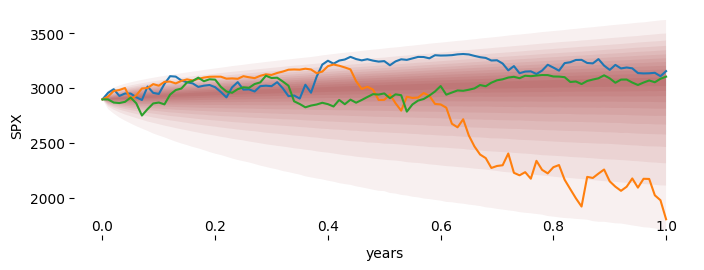

In [18]:
# Step 2: Initialize the Default Heston Model
model = HestonMC(dataset)

# Plot Asset Evolution (Default Dataset)
plot_asset(model, asset_name)

### Dynamic Kernel Density Estimation (KDE) for Asset Price Distributions
To better understand how asset price distributions evolve over time, the notebook employs Kernel Density Estimation (KDE) to visualize price distributions at different time steps.

Instead of using traditional joy plots, KDE plots are generated to show stacked distributions across different time intervals.

Process:

The model is advanced through different time steps (t), and asset prices are recorded at each step.
The KDE plots illustrate how asset price distributions evolve, offering insight into price dispersion over time.


In [19]:
# Step 4: Generate Samples for Different Parameters
times = np.linspace(0.2, 1.0, 5)

def generate_samples(model, times):
    all_prices = []
    all_times = []
    model.reset()
    for t in times:
        model.advance(t)
        prices = model.get_value(asset_name)
        all_prices.extend(prices)
        all_times.extend([f"t={t:4.2f}"] * len(prices))
    return pd.DataFrame({"values": all_prices, "time": all_times})


### Comparing Model Parameters (LONG_VAR, INITIAL_VAR, VOL_OF_VOL, MEANREV, CORRELATION)
The notebook explores the impact of varying Heston model parameters by comparing asset price distributions under different conditions.

In [20]:
# Step 5: KDE Plot Function
def plot_kde(ax, samples_df, title):
    for t in times:
        sns.kdeplot(
            data=samples_df[samples_df['time'] == f"t={t:4.2f}"]['values'],
            ax=ax,
            fill=True,
            label=f"t={t:4.2f}",
            clip=(0, np.max(samples_df['values'])),
            bw_adjust=0.5
        )
    ax.set_xlabel("Asset Price $S(t)$")
    ax.set_title(title)
    ax.legend()

### Visualization: KDE Plots for Parameter Comparisons
For each parameter, the notebook generates side-by-side KDE plots that display price distributions under two different values.
This allows for easy comparison and interpretation of how specific parameters affect price behavior over time.

Plot: Side-by-Side KDE Comparisons

The left subplot shows the KDE plot for the lower parameter value.
The right subplot displays the KDE plot for the higher parameter value.
By comparing the plots, users can analyze how asset prices evolve under different model assumptions.


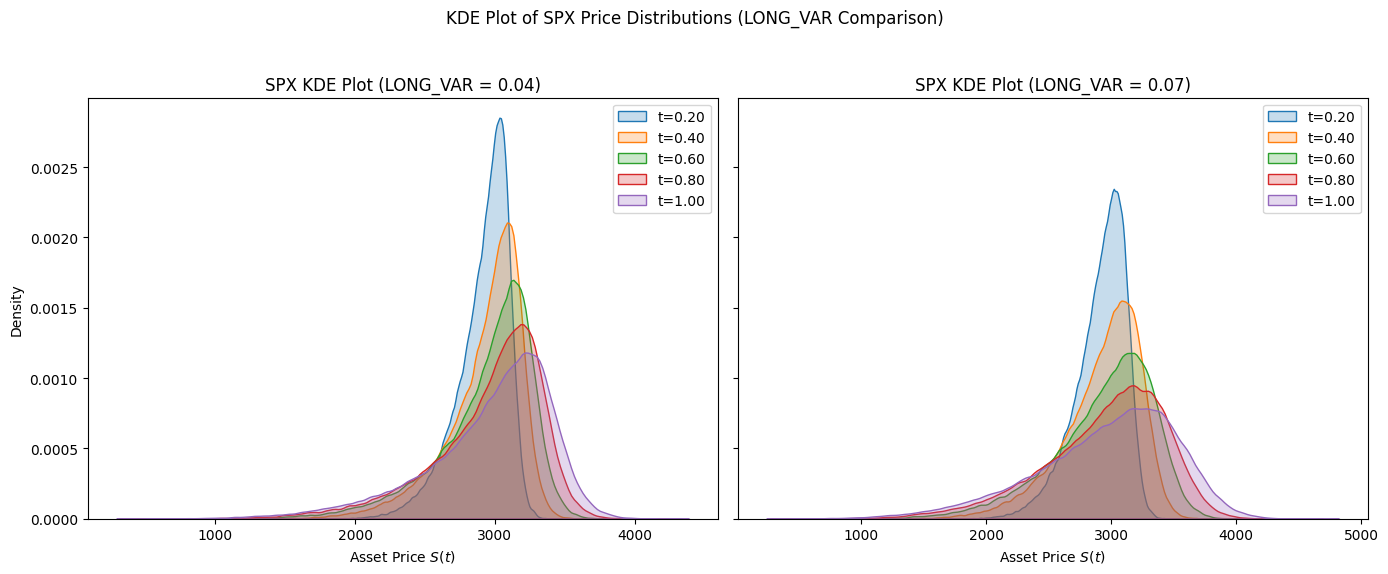

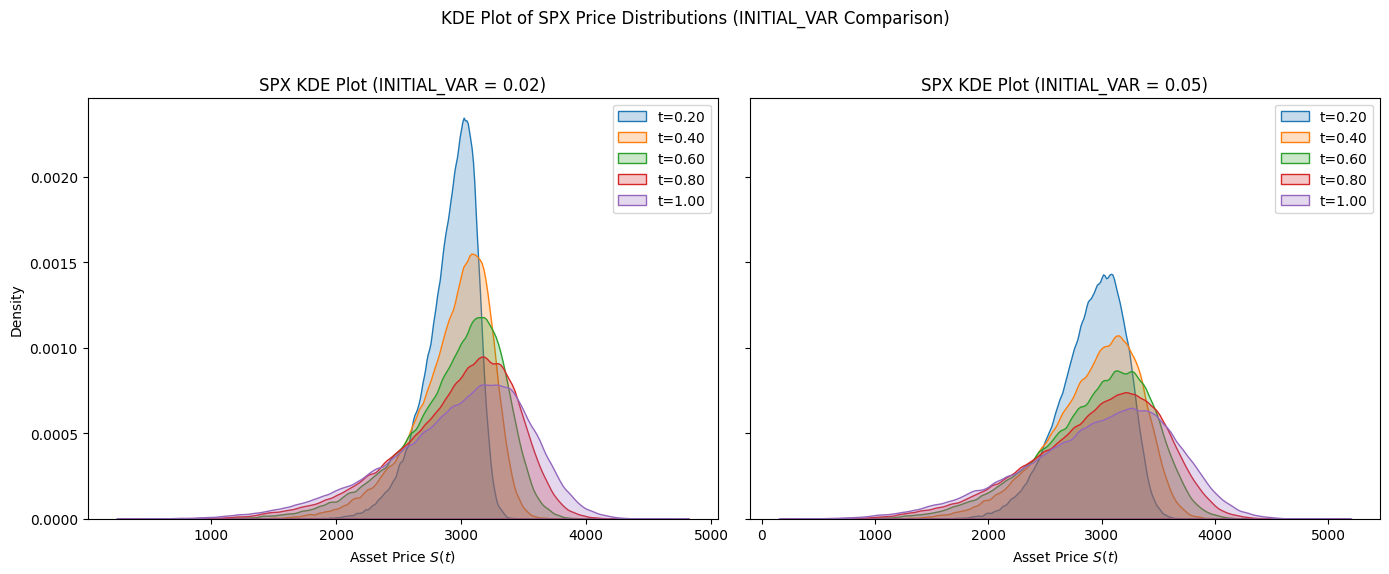

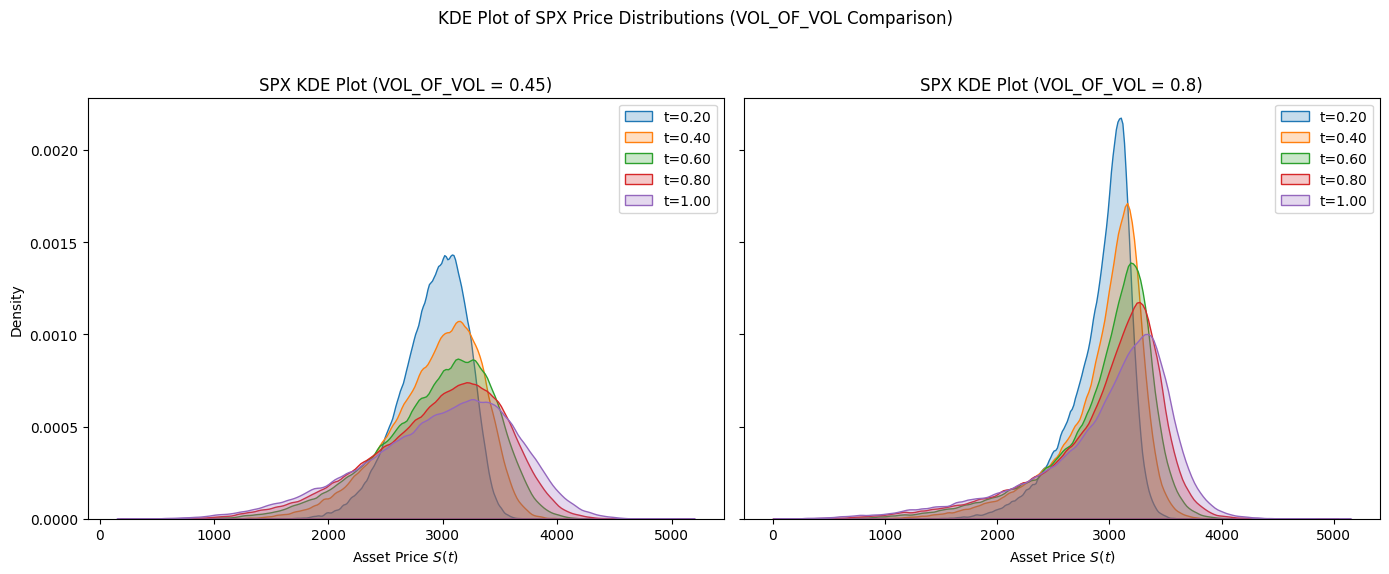

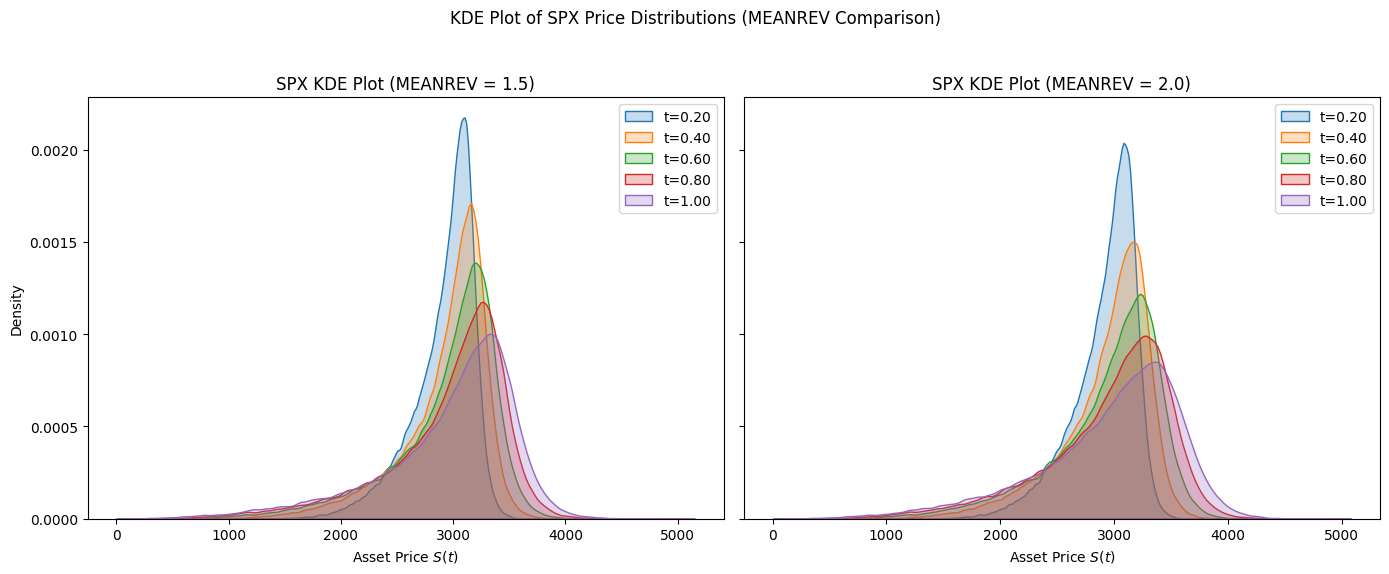

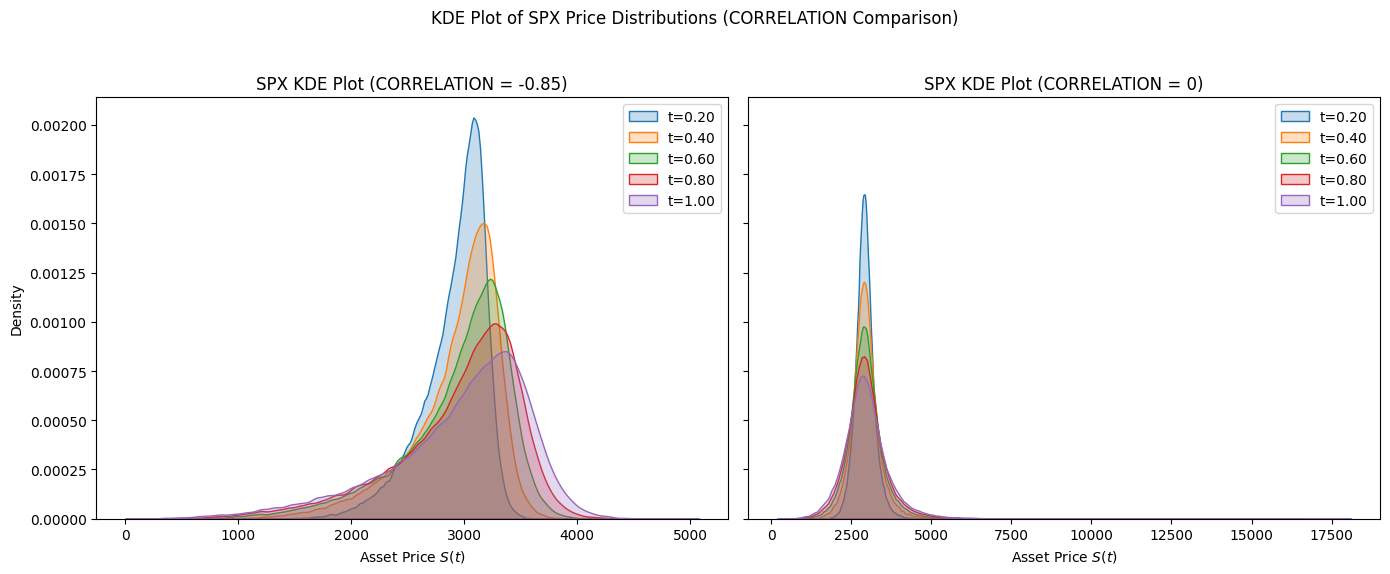

In [21]:
# Step 6: Plot for Different Parameters (Loop)
parameters = [
    ("LONG_VAR", [0.04, 0.07]),
    ("INITIAL_VAR", [0.02, 0.05]),
    ("VOL_OF_VOL", [0.45, 0.8]),
    ("MEANREV", [1.5, 2.0]),
    ("CORRELATION", [-0.85, 0]),
]

for param, values in parameters:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    plt.suptitle(f"KDE Plot of {asset_name} Price Distributions ({param} Comparison)")

    for i, value in enumerate(values):
        dataset["HESTON"][param] = value
        samples_df = generate_samples(model, times)
        plot_kde(axes[i], samples_df, f"{asset_name} KDE Plot ({param} = {value})")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #plt.show()